In [1]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]

In [5]:
df = pd.read_csv("train.csv")
test_X = pd.read_csv("test.csv")
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)

print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)

print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

df['bmi'] = df['weight']/((df['height']/100)**2)
test_X['bmi'] = test_X['weight']/((test_X['height']/100)**2)

Diastilic pressure is higher than systolic one in 68 cases
Diastilic pressure is higher than systolic one in 0 cases


In [7]:
X = df.copy()
y = X.pop("cardio")

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.90, random_state=42)
df.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,17363,1,172,89.0,110,70,1,1,0,1,0,0,30.083829
1,21200,1,168,68.0,110,70,1,1,0,0,1,0,24.092971
2,17286,1,167,74.0,120,80,1,1,0,0,1,0,26.533759
4,20458,1,156,55.0,110,70,1,1,0,0,1,0,22.600263
5,21046,1,156,66.0,110,70,2,1,0,0,1,0,27.120316
6,21168,1,160,85.0,120,80,1,1,0,0,0,1,33.203125
7,19797,1,153,78.0,160,100,1,1,0,0,1,1,33.320518
8,20195,2,159,94.0,130,80,1,1,0,0,1,1,37.182073
9,16940,1,154,55.0,120,80,1,2,0,0,1,0,23.191095
10,17976,1,164,70.0,130,90,1,1,0,0,1,0,26.026175


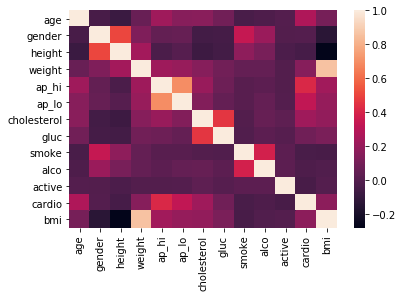

In [9]:
sns.heatmap(df.corr())
plt.show()

In [174]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

regressor = RandomForestRegressor(n_estimators=1000, max_depth = 3, random_state=0)
regressor.fit(train_X, train_y)
pred_y = regressor.predict(val_X)
print('Mean Absolute Error:', metrics.mean_absolute_error(pred_y, val_y))
print('Mean Squared Error:', metrics.mean_squared_error(pred_y, val_y))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(pred_y, val_y)))


Mean Absolute Error: 0.41362580295023343
Mean Squared Error: 0.20317151311571877
Root Mean Squared Error: 0.45074550814813313


In [12]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['gender', 'smoke', 'alco', 'active']
NUMERIC_COLUMNS = ['height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'bmi']

def one_hot_cat_column(feature_name, vocab):
    return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    # Need to one-hot encode categorical features.
    vocabulary = train_X[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

In [16]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(train_y)

def make_input_fn(X, y=None, n_epochs=1, shuffle=False):
    def input_fn():
        if (y is None):
            dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list')))
        else:
            dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).
        dataset = (dataset
          .repeat(n_epochs)
          .batch(NUM_EXAMPLES))
        return dataset
    return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(train_X, train_y, 10)
eval_input_fn = make_input_fn(val_X, val_y)
test_input_fn = make_input_fn(test_X)

In [37]:
'''
params = {
    'n_trees': 15,
    'max_depth': 3,
    'n_batches_per_layer': 1,
    'learning_rate': 0.05,
    #'l1_regularization': 0.0, 
    #'l2_regularization': 0.01,
    # You must enable center_bias = True to get DFCs. This will force the model to
    # make an initial prediction before using any features (e.g. use the mean of
    # the training labels for regression or log odds for classification when
    # using cross entropy loss).
    'center_bias': True, 
}
'''
params = {
    'n_trees': 500,
    'max_depth': 3,
    'n_batches_per_layer': 1,
    'learning_rate': 0.2,
    #'l1_regularization': 0.0, 
    #'l2_regularization': 0.01,
    # You must enable center_bias = True to get DFCs. This will force the model to
    # make an initial prediction before using any features (e.g. use the mean of
    # the training labels for regression or log odds for classification when
    # using cross entropy loss).
    'center_bias': True, 
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=1000)

# Evaluation.
results = est.evaluate(train_input_fn)
print(type(results))
pd.Series(results).to_frame()#

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpm1rrp0zy', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


,0
accuracy,0.752907
accuracy_baseline,0.502907
auc,0.831102
auc_precision_recall,0.840901
average_loss,0.541901
label/mean,0.497093
loss,0.541901
precision,0.794521
prediction/mean,0.496997
recall,0.678363


In [40]:
test_Y = est.predict(test_input_fn)
pred = pd.Series(test_Y)
logistic = np.array([row['logistic'][0] for row in pred])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpm1rrp0zy/model.ckpt-9
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [32]:
csv = pd.DataFrame(data={"cardio": logistic > 0.5}, dtype=np.int8)
csv.head()

,cardio
0,0.741536
1,0.329920
2,0.298194
3,0.741536
4,0.284340


In [26]:
csv.to_csv("4.csv")